## Demonic Blend ##

The goal is to blend two images, keeping the raw features of one while infusing the style of the other.

##### Intuition : #####

The goal is to extract the style of an image.

A first naive way would be to train an image to have the same residual stream as another. While passing an image through a CNN, the activations represent different level of abstractions, different features of an image. The idea is that the residual stream contains the information about the style. However it also contains a lot of information about the position.
This raw information can tell us where to find curves, collor gradients, etc. in the image.
Thus, if we train an image directly on this metric, we will simply end up reconstructing the style image, and we won't extract anything at all.

A more clever way to extract the style is the following.
We will define the style of an image as the correlation between the different features of the image.
To compute it we simply make the matrix of the dot product of the features of the image with themselves. See $objectives.feature\_corelation\_matrix$.
The idea is as follows :

If two features happen to be correlated in the "style" image, we want them to be correlated in the "blended" image as well.
For example, if in the style image, the curve detectors are systematically triggered when there is a line of yellow surrounded by blue,
we want the same to happen in the blended image.
If circles always co occur with color gradient between red and green, we want circles in the blended image to behave the same way.

This way, the position of the features in the original image are preserved
while the relation between those features, color, gradient, sharpness, ... are replaced by the ones of the style image.


Note : Originally, I also included the objective for the image to stay the same. To do so, I used the first method described above as it would preserve the spaciality of features, but it turns out that it is not useful. This is because the correlation matrix completely disregards the position of the features, so they will be naturally preserved.


In [1]:
import torch
import torch.nn as nn

import torchvision.models as models

from torchvision import transforms as ttransforms

from matplotlib import pyplot as plt

from tqdm import tqdm

import images
import objectives

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = models.vgg19(pretrained=True).features.eval()

c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
########
# Parameters
########

FOURRIER = False
RANDOM_INIT = False
ApplyTFORM = False
BIG = True

base_img_path = "images/quenelle_BW_NEG.jpg"
style_img_path = "images/Stripes_Style.jpg"

size = 1000 if BIG else (224, 398)

style_layers = [
    'conv_1',
    'conv_2',
    'conv_3',
    'conv_4',
    'conv_5'
]

In [4]:
style_img = images.ExistingImage(style_img_path, resize=size, train=False)().detach()

blend_img = images.ExistingFourierImage(base_img_path, resize=size) if FOURRIER else images.ExistingImage(base_img_path, resize=size)
if RANDOM_INIT :
    blend_img = images.Image(size[1], h=size[0], fft=False, decorrelate=False)

In [5]:
style_obj = objectives.stream_difference(model, style_layers, style_img, transform=objectives.feature_corelation_matrix)

objective = style_obj

In [6]:
def train(model, objective, param, transforms = None, epochs = 100, lr = 0.01, verbose = True, ultraverbose = False):
    """
    This function trains some parameters to minimize some objective.

    model : the model we are examining through feature visualization

    objective : the objective we are trying to minimize.
                e.g. the mean activation of a neuron, or the mean activation of a channel
                or darker stuff for demonic blend.
    
    param : the parameters we are trying to optimize.
            e.g. an image we want to train.
    
    transforms : a list of transforms to apply to the parameters before feeding them to the model.
                 when training an image this helps for resilience to noise.
                
    epochs : the number of epochs to train for.

    verbose : whether to print the loss over time.
    """

    param.train()

    if verbose:
        losses = []
    
    parameters = param.parameters()
    opt = torch.optim.Adam(parameters, lr=lr)

    for epoch in tqdm(range(epochs)) if verbose else range(epochs):
        opt.zero_grad()
        loss = objective(model, param, transforms)
        loss.backward()
        opt.step()
        if verbose:
            losses.append(loss.item())

        if epoch / epochs * 10 % 1 == 0 and ultraverbose:
            image = param()
            print(image.min(), image.max())
            images.imshow(image)
    
    if verbose:
        fig, ax = plt.subplots()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Loss over time')
        ax.plot(losses)
        plt.show()
    
    return param

def visualise(model, objective, param, epochs=500, lr=10, verbose=True, ultraverbose=False, save=None):
    if ApplyTFORM:
        # It is verry strange but making the image resilient to transformations makes it worse (the style is not transfered at all)
        transform1 = images.preprocess_image
        transform2 = images.TFORM
        transform3 = images.RESIZE(size)
        transforms = ttransforms.Compose([transform1, transform2, transform3])
    else:
        transforms = images.preprocess_image
    image = train(model, objective, param, transforms=transforms, epochs=epochs, lr = lr, verbose=verbose, ultraverbose=ultraverbose)
    
    if save is None:
        images.imshow(image())
    else:
        images.save_image(image(), save)

100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


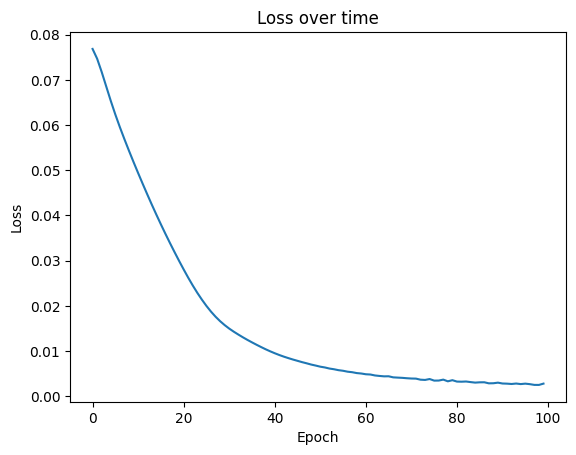

In [7]:
visualise(model, objective, blend_img, lr=1e-2, epochs=100, save = "images/zzt.jpg")